In [2]:
import numpy as np
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sb

az.style.use("arviz-darkgrid")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model

Let's assume that a Nuclear Power Plant's (NPP) power output is unknown and shall be inferred. We know about reactors of similar types the following:

- 20 employees per 100 MW
- 1 cooling tower per 500 MW
- 1 transformers per 250 MW, incl. redundancy
- 10 kg/(yr * MWt) of waste

We can observe these variables; let's try to predict the power. The true value for power is: **1400MW**. There is also an unknown parameter $\eta$ (efficiency) of **0.38**.

-> from this, we get theoretical values:
- 280 employees,
- $1400 / 0.38 = 3684 MWt$ -> 7.4 cooling towers,
- 6 transformers,
- 14000/0.38 = 36842 kg waste per year.

Let's say the assumptions are not perfect, or our observations are faulty. We observe:

- 250 cars outside the plant every morning
- 7 cooling towers (hard to hide one; they are driven a bit harder because expensive)
- 7 transformers (too much redundancy!)
- and we assume that the Castor containers contain 6 x 6 tons = 36000 kg.

It is difficult with two unknown parameters to now derive probabilities for different combinations of power and efficiency grade.

But we know that the power plant has more than 1000 MW and less than 2000 MW power, and efficiencies for nuclear power plants are usually between 0.3 and 0.4 with a higher probability somewhere in the middle. We make no assumption other than that; this and the observations are our priors.

By using the Bayesian approach -- updating a (here flat) prior using some observations, we can get a numeric probability distribution for the power. 


In [3]:
employees = 250
towers = 7
trafos = 7
waste = 36000

In [20]:
with pm.Model() as nppmodel:
    power_e = pm.Uniform("power_e", lower=1000, upper=2000)
    eta = pm.TruncatedNormal("eta", lower=0, mu=0.35, sigma=0.05)
    
    o_empl = pm.Normal("employees", mu=power_e * 0.2, sigma=30, observed=employees)
    o_towers = pm.Normal("towers", mu=power_e / (eta*500), sigma=1, observed=towers)
    o_trafos = pm.Normal("transformers", mu=power_e / 250, sigma=1, observed=trafos)
    o_waste = pm.Normal("waste", mu=power_e / eta * 10, sigma=4000, observed=waste)

In [21]:
with nppmodel:
    trace = pm.sample(8_000, return_inferencedata=True)
    tracemh = pm.sample(8_000, return_inferencedata=True, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, power_e]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 7 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [eta]
>Metropolis: [power_e]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 4 seconds.
The number of effective samples is smaller than 10% for some parameters.


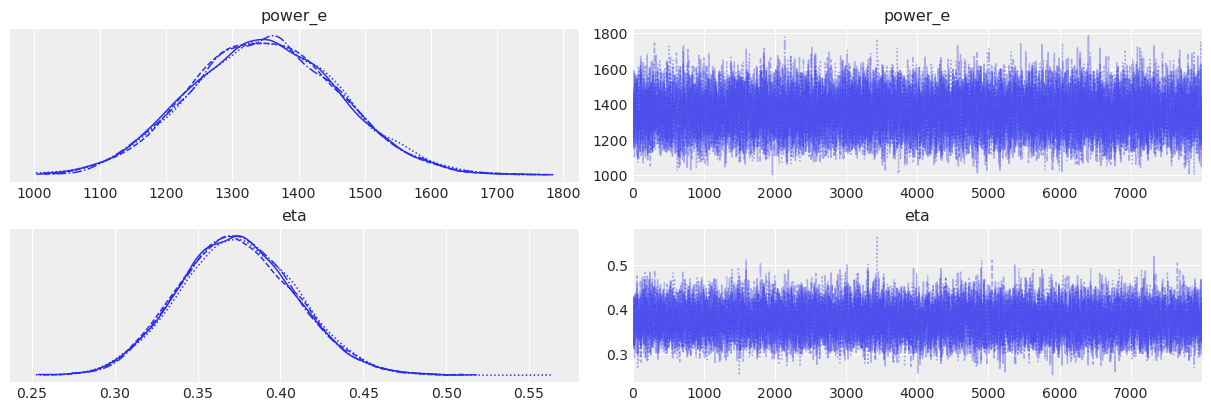

In [22]:
az.plot_trace(trace)
plt.savefig('out/npp_trace.pdf')

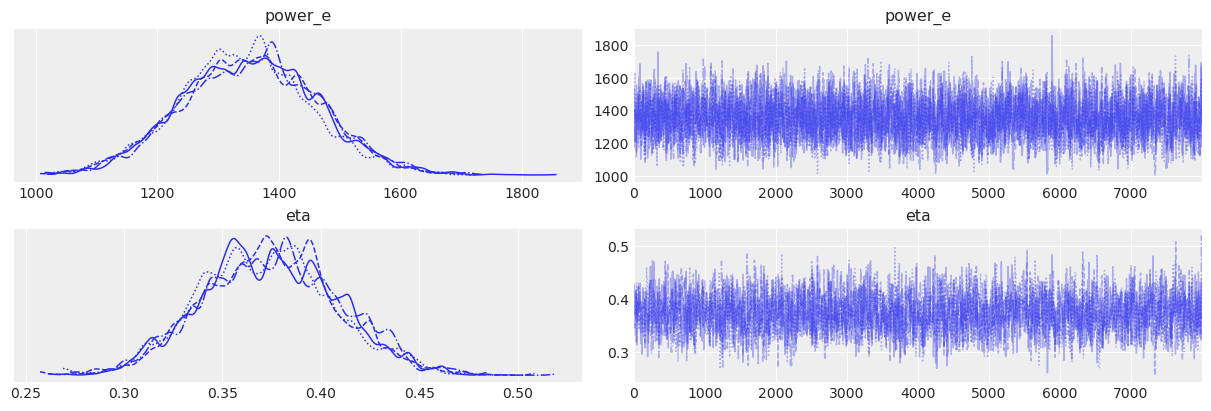

In [23]:
az.plot_trace(tracemh)
plt.savefig('out/npp_trace_mh.pdf')

That seems pretty close. We see that the observations contributing to higher power estimates are reflected as an asymmetric tail.

The summary shows a prediction which is really not bad, quite accurate in fact! (of course the closeness of prediction to the actual value is a coincidence)

In [24]:
az.summary(trace)

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
power_e  1348.778  112.130  1141.820  1561.526      1.006    0.711   12306.0   
eta         0.374    0.035     0.308     0.438      0.000    0.000   12283.0   

         ess_tail  r_hat  
power_e   13441.0    1.0  
eta       15815.0    1.0

In [25]:
az.plot_density(trace)

array([[<AxesSubplot:title={'center':'power_e'}>,
        <AxesSubplot:title={'center':'eta'}>]], dtype=object)

## random walk

show random walk of sampling algorithms

In [26]:
fig = plt.Figure(figsize=(8, 8))

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

ax = fig.add_axes(rect_scatter)
ax_hx = fig.add_axes(rect_histx, sharex=ax)
ax_hy = fig.add_axes(rect_histy, sharey=ax)

ax.set_xlabel('power_e')
ax.set_ylabel('eta')
ax_hx.tick_params(axis='x', labelbottom=False)
ax_hy.tick_params(axis='y', labelleft=False)

n_max = 200

for chain in trace.posterior.chain:
    p = trace.posterior.power_e[chain][0:n_max]
    e = trace.posterior.eta[chain][0:n_max]
    ax.plot(p, e, linestyle='solid', alpha=1/2, label=f'chain #{int(chain)+1}')
    ax_hx.hist(p, histtype='step', bins=20)
    ax_hy.hist(e, histtype='step', bins=20, orientation='horizontal')
ax.legend()
fig.savefig('out/npp_walk.pdf')
fig

<ipython-input-26-0070832188de>:31: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('out/npp_walk.pdf')
/home/lbo/.anaconda3/envs/fcjupyter/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


In [27]:
samples = trace.posterior.eta.size

g = sb.jointplot(x=trace.posterior.power_e.to_numpy().reshape(samples), y=trace.posterior.eta.to_numpy().reshape(samples), marker='.')
g.plot_joint(sb.kdeplot)

/home/lbo/.anaconda3/envs/fcjupyter/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


## Prior distributions

The following are the prior distributions, our knowledge. Note that the assumptions are quite broad, i.e. there is a high uncertainty to our observations.

<ipython-input-106-da9631818f21>:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  axs[0][0].savefig("out/npp_prior_rest.pdf")
<ipython-input-106-da9631818f21>:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  axs[1][0].savefig("out/npp_prior_pure.pdf")


[(<Figure size 600x600 with 4 Axes>,
  array([[<AxesSubplot:title={'center':'employees'}>,
          <AxesSubplot:title={'center':'towers'}>],
         [<AxesSubplot:title={'center':'transformers'}>,
          <AxesSubplot:title={'center':'waste'}>]], dtype=object)),
 (<Figure size 600x300 with 2 Axes>,
  array([[<AxesSubplot:title={'center':'power_e'}>,
          <AxesSubplot:title={'center':'eta'}>]], dtype=object))]

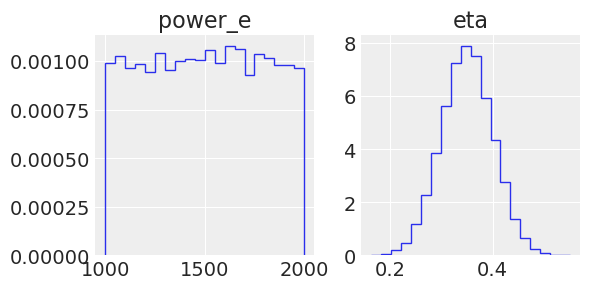

In [106]:
with nppmodel:
    prior = pm.sample_prior_predictive(20000)

priorvars = list(trace.observed_data.keys())
postvars = list(list(trace['posterior'].keys()))

axs = []

for vars in [priorvars, postvars]:
    fig, ax = plt.subplots((len(vars))//2, 2, squeeze=False, figsize=(6, 3*len(vars)//2), tight_layout=1.2)
    for i, var in enumerate(vars):
        cax = ax[i//2, i%2]
        cax.hist(prior[var], histtype='step', bins=20, density=True)
        cax.set_title(var)
        #cax.set_yscale('log')
        #cax.legend()
    axs.append((fig,ax))

axs[0][0].savefig("out/npp_prior_rest.pdf")
axs[1][0].savefig("out/npp_prior_pure.pdf")

axs

## illustrations

In [29]:
import scipy.stats as stats

In [77]:
xs = np.linspace(-4, 4, 1000)
ys = stats.norm.pdf(xs)

ymax = np.max(ys)
xsam = np.sort(np.random.randn(xs.size))
ysam = np.random.rand(xs.size) * stats.norm.pdf(xsam)

# differentiate samples
dxs = np.linspace(-4, 4, 100)
dys = np.zeros_like(dxs)
for i, x in enumerate(dxs[1:]):
    dys[i] = np.sum(np.logical_and(dxs[i-1] <= xsam, xsam < x))
kernel = stats.gaussian_kde(xsam)
kys = kernel(dxs)

<ipython-input-97-0aa3b7e302b5>:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.savefig('out/npp_mc_integration.pdf')


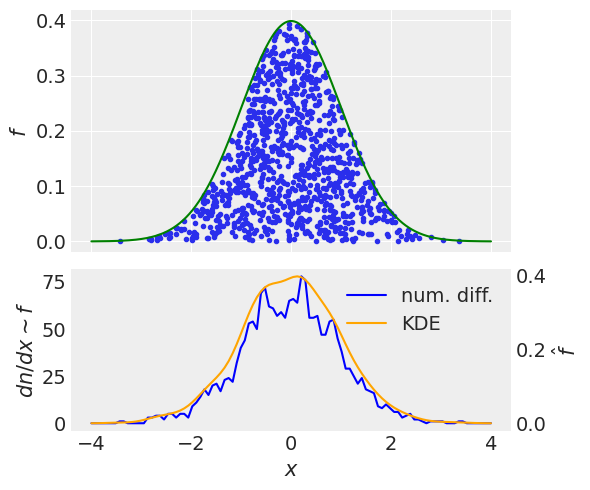

In [96]:
fig = plt.Figure(figsize=(6, 5), tight_layout=True)
ax, ax2 = fig.subplots(2, 1, gridspec_kw=dict(height_ratios=[3,2]), sharex=True)
ax.plot(xs, ys, color='green')
ax.scatter(xsam, ysam, marker='.')

bins = np.linspace(np.min(xs), np.max(xs), 30)
#a = ax2.hist(xsam, bins=bins)
ax22 = ax2.twinx()
p1,= ax2.plot(dxs, dys, color='blue', label='num. diff.')
p2,= ax22.plot(dxs, kys, color='orange', label='KDE')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$dn / dx \\sim f$')
ax22.set_ylabel('$\\hat f$')
ax2.legend([p1,p2], ['num. diff.', 'KDE'])
ax22.grid(False)
ax2.grid(False)
ax.set_ylabel('$f$')

fig.savefig('out/npp_mc_integration.pdf')
fig